1. Setup and Imports

In [16]:
# === Setup ===
import os
from pathlib import Path
import warnings

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.animation as animation

warnings.filterwarnings('ignore', category=UserWarning, append=True)

# results folder (relative to your current notebook: activities/activity3/)
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("CWD:", Path.cwd().resolve())
print("Saving outputs to:", RESULTS_DIR.resolve())



CWD: /Users/nehahooda/Desktop/GitHub/data-science-3337-task-3/activities/activity3
Saving outputs to: /Users/nehahooda/Desktop/GitHub/data-science-3337-task-3/activities/activity3/results


2. Load FITS Files

In [17]:
# === Load RHESSI FITS files (primary HDU only) ===
flare_path   = Path("visuals/rhessi_imagecube_vis_flareM.fits")
noflare_path = Path("visuals/rhessi_imagecube_vis_noflare.fits")  # note: no "M"

print("Flare exists:", flare_path.exists(), "| No-flare exists:", noflare_path.exists())

def load_primary_hdu(path: Path):
    """Return (data, header) from PRIMARY HDU only, tolerant of odd headers."""
    with fits.open(path, mode="readonly", memmap=False, ignore_missing_end=True) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

data_f, header_f   = load_primary_hdu(flare_path)
data_nf, header_nf = load_primary_hdu(noflare_path)

print("Flare shape:   ", data_f.shape)    # expect (bands_f, T_f, H, W)
print("No-flare shape:", data_nf.shape)   # expect (bands_nf, T_nf, H, W)

# unpack for convenience
bands_f, T_f, H_f, W_f     = data_f.shape
bands_nf, T_nf, H_nf, W_nf = data_nf.shape

# choose time index / band indices (customize if you like)
t = 0
band_index_f  = 0
band_index_nf = 0 if bands_nf > 0 else 0


Flare exists: True | No-flare exists: True
Flare shape:    (22, 2, 101, 101)
No-flare shape: (13, 3, 101, 101)


3. Single Time Frame Averaged Across Bands (both files)

/Users/nehahooda/Desktop/GitHub/data-science-3337-task-3/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


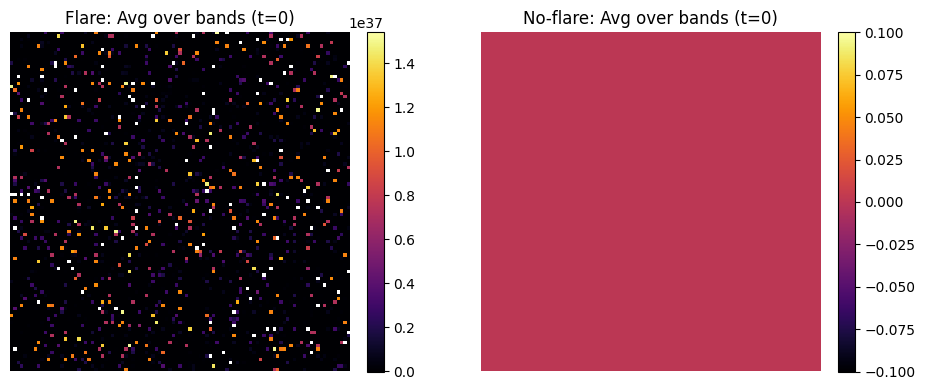

In [18]:
# Average across bands -> (time, y, x), then pick time t
avg_f  = data_f.mean(axis=0)[t]
avg_nf = data_nf.mean(axis=0)[t]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(avg_f,  cmap="inferno", origin="lower")
axs[0].set_title(f"Flare: Avg over bands (t={t})"); axs[0].axis("off"); plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(avg_nf, cmap="inferno", origin="lower")
axs[1].set_title(f"No-flare: Avg over bands (t={t})"); axs[1].axis("off"); plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(RESULTS_DIR / f"avg_frame_comparison_t{t}.png", dpi=200)
plt.show()

4. All Energy Bands for One Time Frame (auto-grid; handles different band counts)

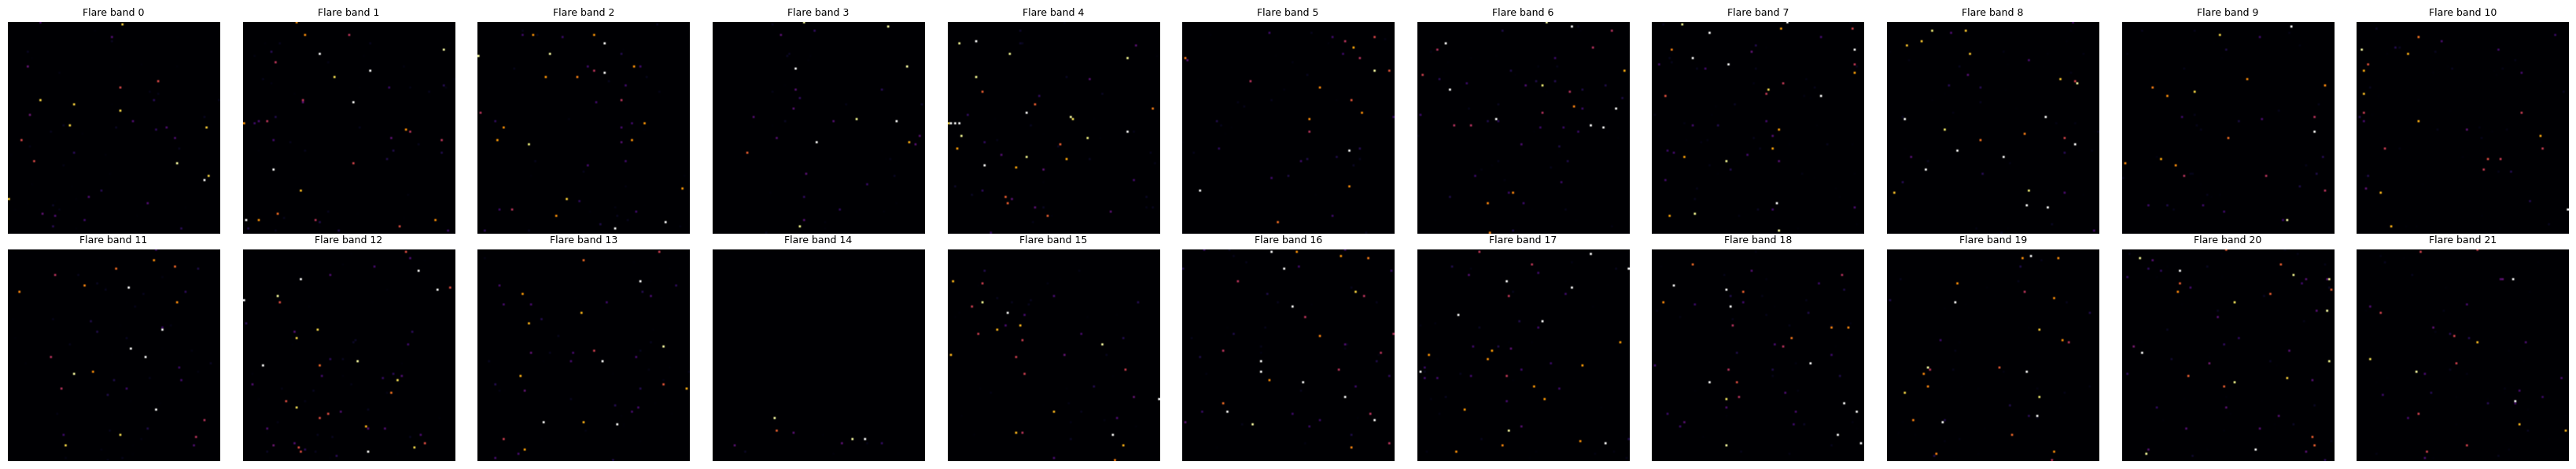

Saved: results/flare_bands_t0.png


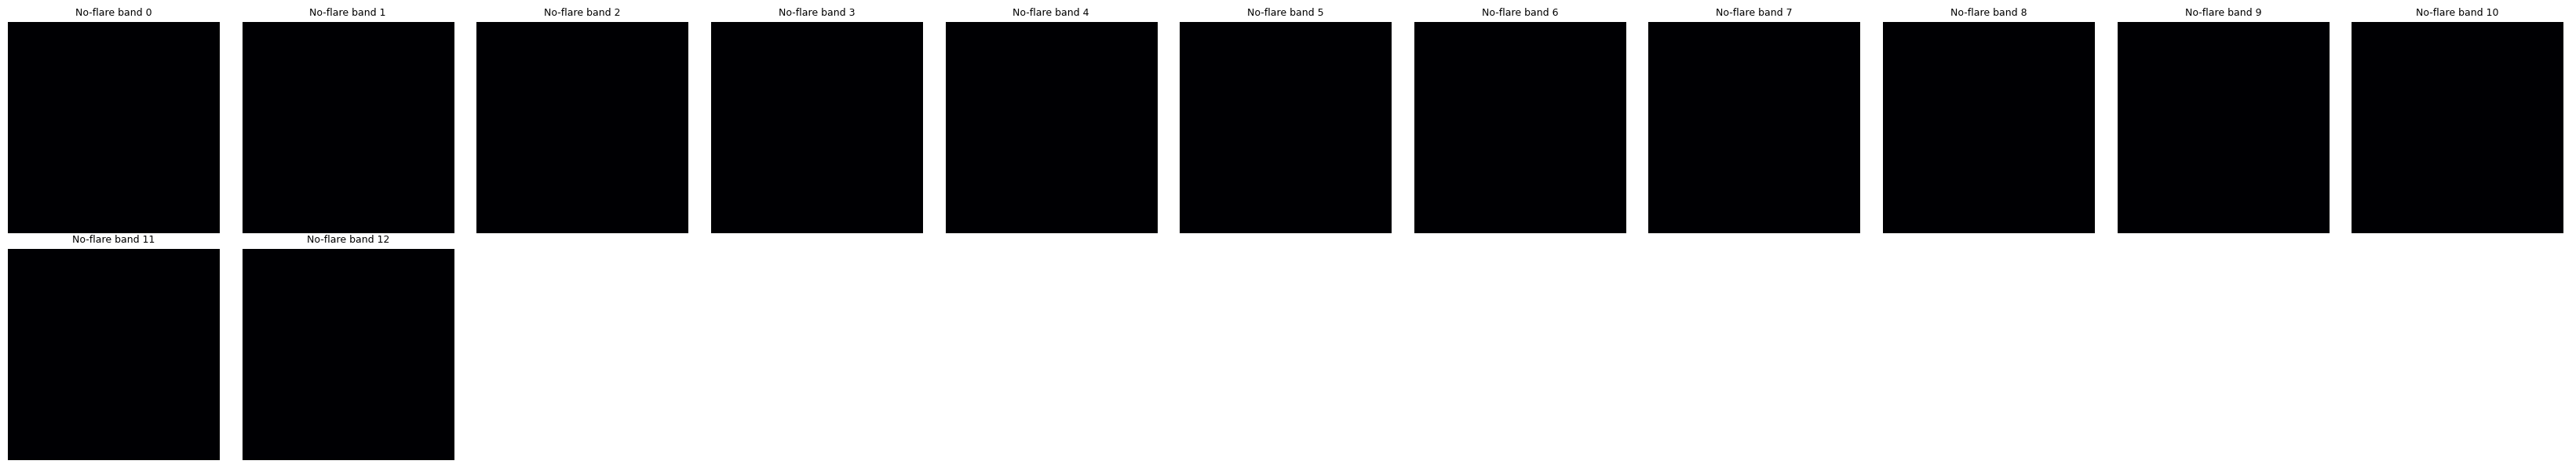

Saved: results/noflare_bands_t0.png


In [19]:
def plot_band_grid(cube, t, label, outname):
    bands = cube.shape[0]
    # Keep the layout readable (wrap to multiple rows if many bands)
    ncols = min(11, bands)
    nrows = int(np.ceil(bands / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axs = np.atleast_2d(axs)

    idx = 0
    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r, c]
            if idx < bands:
                ax.imshow(cube[idx, t], cmap="inferno", origin="lower")
                ax.set_title(f"{label} band {idx}", fontsize=9)
                ax.axis("off")
                idx += 1
            else:
                ax.axis("off")
    plt.tight_layout()
    out = RESULTS_DIR / outname
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

plot_band_grid(data_f,  t, "Flare",    f"flare_bands_t{t}.png")
plot_band_grid(data_nf, t, "No-flare", f"noflare_bands_t{t}.png")



 5. One Energy Band Over Time (both files)

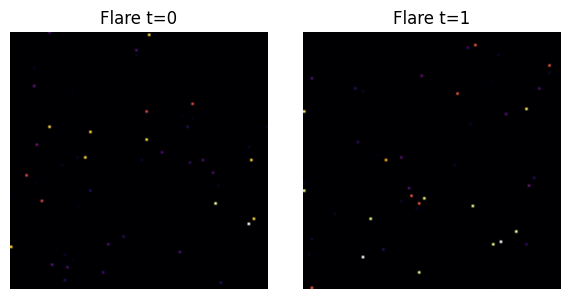

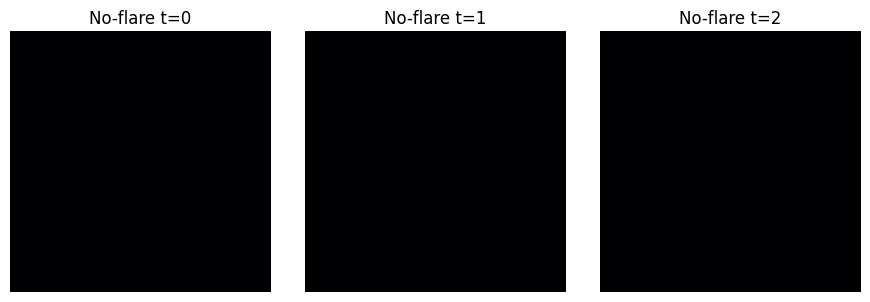

In [20]:
# Flare over time
fig, axs = plt.subplots(1, T_f, figsize=(3*T_f, 3))
for tt in range(T_f):
    axs[tt].imshow(data_f[band_index_f, tt], cmap="inferno", origin="lower")
    axs[tt].set_title(f"Flare t={tt}")
    axs[tt].axis("off")
plt.tight_layout()
plt.savefig(RESULTS_DIR / f"flare_band{band_index_f}_over_time.png", dpi=180)
plt.show()

# No-flare over time
fig, axs = plt.subplots(1, T_nf, figsize=(3*T_nf, 3))
for tt in range(T_nf):
    axs[tt].imshow(data_nf[band_index_nf, tt], cmap="inferno", origin="lower")
    axs[tt].set_title(f"No-flare t={tt}")
    axs[tt].axis("off")
plt.tight_layout()
plt.savefig(RESULTS_DIR / f"noflare_band{band_index_nf}_over_time.png", dpi=180)
plt.show()


6. Animation Over Time

In [21]:
def make_anim(cube, label, band_index=0):
    frames = cube[band_index]  # shape: (time, y, x)
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap="inferno", origin="lower")
    ax.set_title(f"{label} t=0"); ax.axis("off")

    def update(i):
        im.set_array(frames[i])
        ax.set_title(f"{label} t={i}")
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=frames.shape[0], interval=600)
    out_mp4 = RESULTS_DIR / f"{label}_band{band_index}_anim.mp4"
    try:
        ani.save(out_mp4, writer="ffmpeg")
        print("Saved MP4:", out_mp4.resolve())
    except Exception as e:
        out_gif = RESULTS_DIR / f"{label}_band{band_index}_anim.gif"
        ani.save(out_gif, writer=animation.PillowWriter(fps=2))
        print("FFMPEG not available, saved GIF:", out_gif.resolve())
    plt.close(fig)

make_anim(data_f,  "flare",   band_index=band_index_f)
make_anim(data_nf, "noflare", band_index=band_index_nf)


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


FFMPEG not available, saved GIF: /Users/nehahooda/Desktop/GitHub/data-science-3337-task-3/activities/activity3/results/flare_band0_anim.gif
FFMPEG not available, saved GIF: /Users/nehahooda/Desktop/GitHub/data-science-3337-task-3/activities/activity3/results/noflare_band0_anim.gif


7. Pinpoint Flare Location

/Users/nehahooda/Desktop/GitHub/data-science-3337-task-3/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


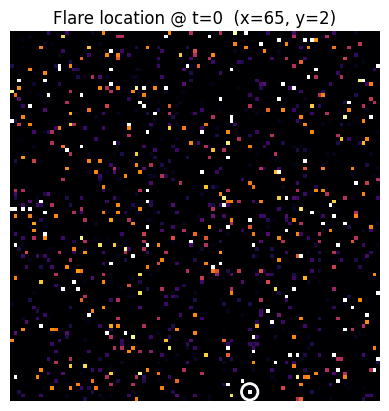

In [22]:
avg_f_t0 = data_f.mean(axis=0)[0]  # average bands, pick time 0
y, x = np.unravel_index(np.argmax(avg_f_t0), avg_f_t0.shape)

plt.imshow(avg_f_t0, cmap="inferno", origin="lower")
plt.scatter(x, y, s=140, facecolors='none', edgecolors='white', linewidths=2)
plt.title(f"Flare location @ t=0  (x={x}, y={y})")
plt.axis("off")
plt.savefig(RESULTS_DIR / "flare_location_marked.png", dpi=200, bbox_inches="tight")
plt.show()